# The Simplest Quantum ROM

We implement here a Qiskit function that takes an input, a classical Boolean function $f:\mathbb F_2^n \to \mathbb F_2^d$, and outputs the oracle
$$
U_f : \ket{x}\ket{y} \mapsto \ket{x}\ket{y \oplus f(x)}
$$
and verify its correctness. This notebook uses a minimal construction suitable for a quick deliverable.

In [1]:
from typing import Dict, List, Tuple
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector

## Synthesis utilities
We represent the truth table as a Python dict `table: Dict[int, int]` mapping an input integer $x\in[0,2^n)$ to an integer encoding the $d$-bit output $f(x)$. The function `build_qrom_circuit` returns a circuit on $n+d$ qubits that implements $\ket{x}\ket{y} \mapsto \ket{x}\ket{y\oplus f(x)}$.

In [2]:
def int_to_bits(val: int, width: int) -> List[int]:
    # Little-endian bits of val with given width
    return [(val >> i) & 1 for i in range(width)]

def bits_to_int(bits: List[int]) -> int:
    out = 0
    for i, b in enumerate(bits):
        out |= ((1 if b else 0) << i)
    return out

def onset_indices(table: Dict[int, int], n: int, d: int, j: int) -> List[int]:
    # Return x in the half-open interval [0, 2**n) such that the j-th output bit of f(x) equals 1
    out = []
    for x in range(1 << n):
        fx = table.get(x, 0)
        if ((fx >> j) & 1) == 1:
            out.append(x)
    return out

In [6]:
def build_qrom_circuit(n: int, d: int, table: Dict[int, int], name: str = "QROM"):

    qc = QuantumCircuit(n + d, name=name)
    controls = list(range(n))
    targets = list(range(n, n + d))

    def apply_mcx(ctrls: List[int], tgt: int):
        try:
            qc.mcx(ctrls, tgt)  # modern API
        except Exception:
            qc.mct(ctrls, tgt)  # legacy API

    for j in range(d):
        ones = onset_indices(table, n, d, j)
        for x in ones:
            xb = int_to_bits(x, n)
            # Pre-flip zeros for negative controls
            zero_positions = [i for i, b in enumerate(xb) if b == 0]
            for i in zero_positions:
                qc.x(controls[i])
            # n-controlled X on target j
            apply_mcx(controls, targets[j])
            # Uncompute the flips
            for i in zero_positions:
                qc.x(controls[i])
    return qc

## Verification helpers
We test on all computational basis states. For $\ket{x}\ket{0^d}$, the output must equal $\ket{x}\ket{f(x)}$.

In [14]:
def eval_f(table: Dict[int, int], x: int, d: int) -> int:
    return table.get(x, 0) & ((1 << d) - 1)

def verify_basis(n: int, d: int, table: Dict[int, int], qc, verbose: bool = True) -> bool:
    """
    Check all basis inputs |x>|0^d> map to |x>|f(x)> by statevector simulation.
    """
    for x in range(1 << n):
        # Prepare |x>|0^d>
        prep = QuantumCircuit(n + d)
        for i in range(n):
            if ((x >> i) & 1) == 1:
                prep.x(i)
        full = prep.compose(qc)
        sv = Statevector.from_instruction(full)
        # Expected basis index for |x>|f(x)>
        y = eval_f(table, x, d)
        # Indexing: little-endian qubits (q_0 is LSB). Build bitstring [control bits, target bits].
        bits = int_to_bits(x, n) + int_to_bits(y, d)
        expected_index = bits_to_int(bits)
        amp = sv.data[expected_index]
        ok = abs(abs(amp) - 1.0) < 1e-9
        if verbose:
            print(f"x={x:0{n}b} -> expected target y={y:0{d}b}, amplitude |{amp}|")
        if not ok:
            return False
    return True

## Worked example: $n=3$, $d=2$

Define $f = (f_0, f_1): \mathbb F_2^3 \to \mathbb F_2^2$ as follows
- $f_0(x) = x_0 \oplus x_1$
- $f_1(x) = 1 \iff x \in \{5, 7\}$

In [8]:
n, d = 3, 2

def f_of_x(x: int) -> int:
    # bits: x0 (LSB), x1, x2
    x0 = (x >> 0) & 1
    x1 = (x >> 1) & 1
    # output bit 0: parity of x0 and x1
    f0 = x0 ^ x1
    # output bit 1: 1 for x in {5,7}
    f1 = 1 if x in (5, 7) else 0
    return (f1 << 1) | f0  # little-endian packing

table = {x: f_of_x(x) for x in range(1 << n)}
table

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 3, 6: 1, 7: 2}

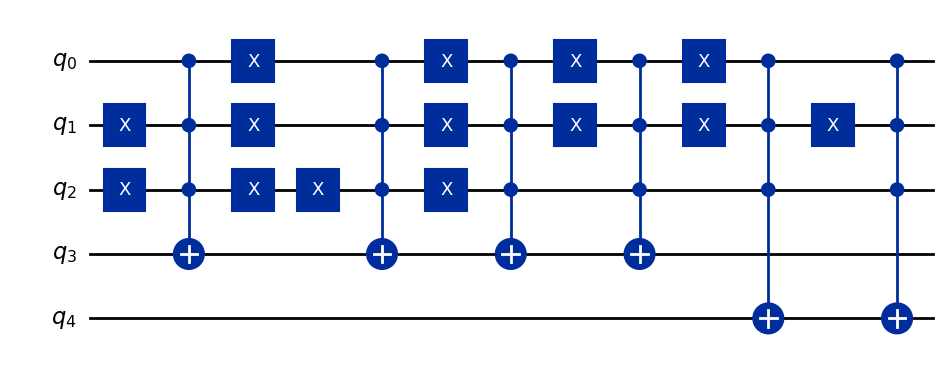

In [10]:
# Build the circuit and visualize
qc = build_qrom_circuit(n, d, table, name="QROM_n3_d2")
qc.draw(output="mpl")

## Tests
Verify on all basis states

In [15]:
ok = verify_basis(n, d, table, qc, verbose=True)

x=000 -> expected target y=00, amplitude |(0.9999999999999991-3.930303294003737e-18j)|
x=001 -> expected target y=01, amplitude |(0.9999999999999988-3.1230997565546893e-17j)|
x=010 -> expected target y=01, amplitude |(0.999999999999999+1.8683756738431255e-17j)|
x=011 -> expected target y=00, amplitude |(0.9999999999999988-6.749540473375347e-17j)|
x=100 -> expected target y=00, amplitude |(0.999999999999999-4.9914754303978145e-17j)|
x=101 -> expected target y=11, amplitude |(0.999999999999999+6.954091003752534e-17j)|
x=110 -> expected target y=01, amplitude |(0.999999999999999+1.3650347135771578e-17j)|
x=111 -> expected target y=10, amplitude |(0.9999999999999991-6.655300573863753e-17j)|
